# Using Tensorflow library for Airfoil use case

In [ ]:
import os
import matplotlib.pyplot as plt
from lips import get_root_path
from lips.dataset.airfransDataSet import download_data
from lips.benchmark.airfransBenchmark import AirfRANSBenchmark

In [2]:
# Use a GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # Visible devices must be set at program startup
        print(e)

In [3]:
# see the list of selected devices
tf.config.experimental.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# indicate required paths
LIPS_PATH = get_root_path()
DIRECTORY_NAME = 'Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = LIPS_PATH + "lips_logs.log"

In [5]:
BENCH_CONFIG_PATH = LIPS_PATH + os.path.join("..","configurations","airfoil","benchmarks","confAirfoil.ini") #Configuration file related to the benchmark
SIM_CONFIG_PATH = LIPS_PATH + os.path.join("..","configurations","airfoil","simulators","tf_fc.ini") #Configuration file related to the simulator

In [ ]:
benchmark=AirfRANSBenchmark(benchmark_path = DIRECTORY_NAME,
                            config_path = BENCH_CONFIG_PATH,
                            benchmark_name = BENCHMARK_NAME,
                            log_path = LOG_PATH)
benchmark.load(path=DIRECTORY_NAME)

In [7]:
print("Input attributes (features): ", benchmark.config.get_option("attr_x"))
print("Output attributes (targets): ", benchmark.config.get_option("attr_y"))

Input attributes (features):  ('x-position', 'y-position', 'x-inlet_velocity', 'y-inlet_velocity', 'distance_function', 'x-normals', 'y-normals')
Output attributes (targets):  ('x-velocity', 'y-velocity', 'pressure', 'turbulent_viscosity')


In [11]:
from lips.augmented_simulators.tensorflow_models.airfoil.fully_connected import TfFullyConnectedAirfoil
from lips.dataset.scaler import StandardScaler

tf_fc = TfFullyConnectedAirfoil(name="tf_fc",
                                bench_config_path=BENCH_CONFIG_PATH,
                                bench_config_name=BENCHMARK_NAME,
                                sim_config_path=SIM_CONFIG_PATH,
                                sim_config_name="DEFAULT",
                                scaler=StandardScaler,
                                log_path=LOG_PATH)

In [ ]:
tf_fc.train(train_dataset=benchmark.train_dataset,
            epochs=200
           )

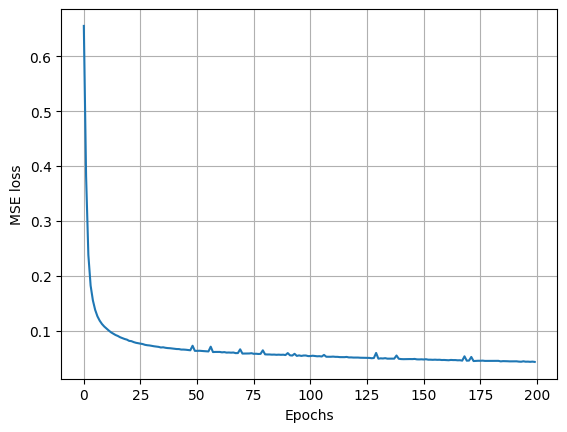

In [52]:
plt.plot(tf_fc.train_losses)
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.grid()
plt.show()

In [53]:
print("Number of parameters :", tf_fc.count_parameters())

Number of parameters : 19604


In [ ]:
tf_fc.summary()

### Evaluation

#### Evaluate without LIPS

In [ ]:
# import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [54]:
# perform predictions
predictions = tf_fc.predict(benchmark._test_dataset)

In [55]:
# Perform Evaluation
for attr_ in benchmark.config.get_option("attr_y"):
    print("MAE", attr_, ":", mean_absolute_error(benchmark._test_dataset.data[attr_], predictions[attr_]))
    print("MSE", attr_, ":", mean_squared_error(benchmark._test_dataset.data[attr_], predictions[attr_]))
    #print("MAPE", attr_, ":", mean_absolute_percentage_error(benchmark._test_dataset.data[attr_], predictions[attr_]))

MAE x-velocity : 11.510057248820305
MSE x-velocity : 379.7969272690724
MAE y-velocity : 8.1926600307695
MSE y-velocity : 364.7702359287913
MAE pressure : 706.4891012240201
MSE pressure : 4500353.282501297
MAE turbulent_viscosity : 0.0056760896314327755
MSE turbulent_viscosity : 9.305277791379357e-05


#### Evaluate with LIPS

In [62]:
# TODO: log the losses
# EVAL_SAVE_PATH = get_path(EVALUATION_PATH, benchmark1)
tf_fc_metrics = benchmark.evaluate_simulator(augmented_simulator=tf_fc,
                                             eval_batch_size=256000,
                                             dataset="test",
                                             shuffle=False,
                                             save_path=None,
                                             save_predictions=False
                                            )

In [21]:
tf_fc_metrics

{'test': {'ML': {'MSE': {'x-velocity': 272.23467037559135,
    'y-velocity': 271.8989492690839,
    'pressure': 3711146.864414714,
    'turbulent_viscosity': 0.0008568147359750647},
   'MSE_surfacic': {'pressure': 0.0008568147359750647},
   'MAPE': {'x-velocity': 221063702794075.84,
    'y-velocity': 213079396602493.28,
    'pressure': 8.785509375425688,
    'turbulent_viscosity': 865561655969.5411},
   'MAPE_surfacic': {'pressure': 865561655969.5411}},
  'Physics': {'spearman_correlation_drag': 0.16308407710192757,
   'spearman_correlation_lift': 0.7530428260706519,
   'mean_relative_drag': 22.901577984573937,
   'std_relative_drag': 10.140640623544623,
   'mean_relative_lift': 1.2876093190592994,
   'std_relative_lift': 3.197885752306768},
  'IndRed': {}}}